In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import lightgbm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Reading data and Verifying it

In [2]:
train = pd.read_csv("/content/drive/My Drive/AV_Agriculture/train_yaOffsB.csv")
test = pd.read_csv("/content/drive/My Drive/AV_Agriculture/test_pFkWwen.csv")
submission_sample = pd.read_csv("/content/drive/My Drive/AV_Agriculture/sample_submission_O1oDc4H.csv")

In [3]:
train.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,F00000001,188,1,0,1,0,0.0,0,1,0
1,F00000003,209,1,0,1,0,0.0,0,2,1
2,F00000004,257,1,0,1,0,0.0,0,2,1
3,F00000005,257,1,1,1,0,0.0,0,2,1
4,F00000006,342,1,0,1,0,0.0,0,2,1


In [4]:
train.isnull().sum()

ID                            0
Estimated_Insects_Count       0
Crop_Type                     0
Soil_Type                     0
Pesticide_Use_Category        0
Number_Doses_Week             0
Number_Weeks_Used          9000
Number_Weeks_Quit             0
Season                        0
Crop_Damage                   0
dtype: int64

In [5]:
test.isnull().sum()

ID                            0
Estimated_Insects_Count       0
Crop_Type                     0
Soil_Type                     0
Pesticide_Use_Category        0
Number_Doses_Week             0
Number_Weeks_Used          5893
Number_Weeks_Quit             0
Season                        0
dtype: int64

In [6]:
train.shape

(88858, 10)

In [7]:
test.isnull().sum()

ID                            0
Estimated_Insects_Count       0
Crop_Type                     0
Soil_Type                     0
Pesticide_Use_Category        0
Number_Doses_Week             0
Number_Weeks_Used          5893
Number_Weeks_Quit             0
Season                        0
dtype: int64

In [8]:
test.shape

(59310, 9)

### Combining the dataframe

In [9]:
def combine_df(train,test):
  train['is_train'] = 1
  test['is_train'] = 0
  return pd.concat([train,test],axis=0)

In [10]:
combined = combine_df(train,test)

In [11]:
## if the Pesticide_Use_Category = 0 then number of weeks used is 0

## Filling Missing values

In [12]:
imp_iter = IterativeImputer(random_state=0)

In [13]:
combined.shape

(148168, 11)

In [159]:
combined_df = pd.concat([combined['ID'],pd.DataFrame(imp_iter.fit_transform(combined.iloc[:,1:]),columns=combined.columns[1:],index=combined.index)],axis=1)

In [160]:
combined_df.isnull().sum()

ID                         0
Estimated_Insects_Count    0
Crop_Type                  0
Soil_Type                  0
Pesticide_Use_Category     0
Number_Doses_Week          0
Number_Weeks_Used          0
Number_Weeks_Quit          0
Season                     0
Crop_Damage                0
is_train                   0
dtype: int64

## Helpful methods

In [161]:
def print_score(m):
  all_metrics = [m.score(X_train,y_train),m.score(X_valid,y_valid)]
  if hasattr(m,"oob_score"):
    all_metrics.append(m.oob_score)
  return all_metrics 

## Converting ordinal values to one hot encoding

In [162]:
combined_df.head()

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,is_train
0,F00000001,188.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,F00000003,209.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0
2,F00000004,257.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0
3,F00000005,257.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0
4,F00000006,342.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0


In [163]:
## ordinal values in the features are providing us misleading information. converting them to one-hot encoding
## converting pesticide_Use_Category, Crop type, Soil Type and Season


In [164]:
combined_df = pd.get_dummies(combined_df,columns=['Crop_Type','Soil_Type','Pesticide_Use_Category','Season'])

## Feature Engineering

In [165]:
combined_df['Number_Doses_Day'] = combined_df['Number_Doses_Week'] / 7.0

In [166]:
combined_df['Number_Days_Used'] = combined_df['Number_Weeks_Used'] * 7.0
combined_df['Number_Days_Quit'] = combined_df['Number_Weeks_Quit'] * 7.0
combined_df['total_dosage'] = combined_df['Number_Doses_Week'] * combined_df['Number_Weeks_Used']

In [167]:
combined_df['total_dosage'].describe()

count    148168.000000
mean        764.757280
std         584.865378
min           0.000000
25%         330.000000
50%         620.000000
75%        1040.000000
max        5510.000000
Name: total_dosage, dtype: float64

In [168]:
#categorising into percentiles
combined_df.loc[(combined_df['total_dosage'] >=0) & (combined_df['total_dosage'] <= 330),"dosage_percentile"] = 1
combined_df.loc[(combined_df['total_dosage'] >330) & (combined_df['total_dosage'] <= 620),"dosage_percentile"] = 2
combined_df.loc[(combined_df['total_dosage'] > 620) & (combined_df['total_dosage'] <= 1040),"dosage_percentile"] = 3
combined_df.loc[(combined_df['total_dosage'] > 1040) & (combined_df['total_dosage'] <= 5510),"dosage_percentile"] = 4

In [169]:
combined_df['dosage_percentile'].value_counts()

1.0    37625
4.0    36933
2.0    36931
3.0    36679
Name: dosage_percentile, dtype: int64

In [170]:
from sklearn.cluster import KMeans  
kmeans = KMeans(n_clusters=5).fit(combined_df.drop(['ID','is_train','Crop_Damage'],axis=1))

In [171]:
predict=kmeans.predict(combined_df.drop(['ID','is_train','Crop_Damage'],axis=1))

In [172]:
combined_df['cluster'] = pd.Series(predict)

In [173]:
combined_df['total_weeks'] = combined_df['Number_Weeks_Used'] + combined_df['Number_Weeks_Quit']

In [174]:
combined_df['cluster'].value_counts()

0    53641
2    39557
3    24257
4    19210
1    11503
Name: cluster, dtype: int64

## Back to train and test

In [175]:
train_df = combined_df[combined_df['is_train'] == 1].drop("is_train",axis=1)
test_df = combined_df[combined_df['is_train'] == 0].drop("is_train",axis=1)

In [140]:
# from sklearn.utils import resample
# alive = train_df[train_df['Crop_Damage'] == 0]
# other = train_df[train_df['Crop_Damage'] == 1]
# pest = train_df[train_df['Crop_Damage'] == 2]
# other_upsampled = resample(other,
#                           replace=True, # sample with replacement
#                           n_samples=len(alive), # match number in majority class
#                           random_state=27) # reproducible results

# pest_upsampled = resample(pest,
#                           replace=True, # sample with replacement
#                           n_samples=len(alive), # match number in majority class
#                           random_state=27) # reproducible results

# # combine majority and upsampled minority
# train_df = pd.concat([alive, other_upsampled, pest_upsampled],axis=0)

In [176]:
train_df['Crop_Damage'].value_counts()

0.0    74238
1.0    12307
2.0     2313
Name: Crop_Damage, dtype: int64

In [177]:
train_df.head()

,ID,Estimated_Insects_Count,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Crop_Damage,Crop_Type_0.0,Crop_Type_1.0,Soil_Type_0.0,Soil_Type_1.0,Pesticide_Use_Category_1.0,Pesticide_Use_Category_2.0,Pesticide_Use_Category_3.0,Season_1.0,Season_2.0,Season_3.0,Number_Doses_Day,Number_Days_Used,Number_Days_Quit,total_dosage,dosage_percentile,cluster,total_weeks
0,F00000001,188.0,0.0,0.0,0.0,0.0,0,1,1,0,1,0,0,1,0,0,0.0,0.0,0.0,0.0,1.0,0,0.0
1,F00000003,209.0,0.0,0.0,0.0,1.0,0,1,1,0,1,0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,0,0.0
2,F00000004,257.0,0.0,0.0,0.0,1.0,0,1,1,0,1,0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,0,0.0
3,F00000005,257.0,0.0,0.0,0.0,1.0,0,1,0,1,1,0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,0,0.0
4,F00000006,342.0,0.0,0.0,0.0,1.0,0,1,1,0,1,0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,0,0.0


## Normalizing the column Estimated Insects Count

In [178]:
def normalize(df):
    result = df.copy()
    max_value = df["Estimated_Insects_Count"].max()
    min_value = df["Estimated_Insects_Count"].min()
    result["Estimated_Insects_Count_Normalized"] = (df["Estimated_Insects_Count"] - min_value) / (max_value - min_value)
    return result

In [179]:
train_df = normalize(train_df)
test_df = normalize(test_df)

## Train Test split

In [180]:
train_df['Crop_Damage'].value_counts()

0.0    74238
1.0    12307
2.0     2313
Name: Crop_Damage, dtype: int64

In [181]:
X = train_df.drop(["Crop_Damage","ID","Estimated_Insects_Count"],axis=1)
y = train_df['Crop_Damage']

In [182]:
y.shape

(88858,)

In [183]:
X.shape

(88858, 21)

In [184]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,random_state=42)

## Random Forest

In [32]:
m1 = RandomForestClassifier(oob_score = True)

In [113]:
m1.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [114]:
print_score(m1)  

[0.9861013420364066, 0.8136394328156651, True]

In [115]:
m1.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
X_test = test_df.drop(["ID","Crop_Damage","Estimated_Insects_Count"],axis=1)

In [117]:
y_pred = m1.predict(X_test)

In [118]:
submission_test_v1 = pd.concat([test_df['ID'],pd.Series(y_pred)],axis=1)

In [119]:
submission_test_v1.columns = ['ID','Crop_Damage']

In [120]:
submission_test_v1.to_csv("submission_v2.csv",index=False)  #normalized and dummies

In [121]:
submission_test_v1.shape

(59310, 2)

## Lightgbm

In [150]:
m2 = lightgbm.LGBMClassifier(n_estimators=200,learning_rate=0.1)

In [151]:
m2.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [152]:
print_score(m2)

[0.6730107593267142, 0.6652223693958647]

In [110]:
m2.fit(X,y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               scale_pos_weight=0.16254444908018395, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [111]:
X_test = test_df.drop(["ID","Crop_Damage","Estimated_Insects_Count"],axis=1)

In [112]:
y_pred = m2.predict(X_test)

In [113]:
submission_test_v1 = pd.concat([test_df['ID'],pd.Series(y_pred)],axis=1)

In [114]:
submission_test_v1.columns = ['ID','Crop_Damage']

In [115]:
submission_test_v1['Crop_Damage'].value_counts()

0.0    56491
1.0     2810
2.0        9
Name: Crop_Damage, dtype: int64

In [116]:
submission_test_v1.to_csv("submission_v10_lgbm.csv",index=False)  #normalized and dummies

In [96]:
submission_test_v1.shape

(59310, 2)

## Catboost

In [34]:
!pip install catboost
import catboost

In [35]:
m3 = catboost.CatBoostClassifier(iterations=100)

In [134]:
m3.fit(X_train,y_train)

Learning rate set to 0.5
0:	learn: 0.6419984	total: 85.8ms	remaining: 8.5s
1:	learn: 0.5324900	total: 121ms	remaining: 5.93s
2:	learn: 0.4824887	total: 158ms	remaining: 5.11s
3:	learn: 0.4543729	total: 201ms	remaining: 4.82s
4:	learn: 0.4399696	total: 240ms	remaining: 4.55s
5:	learn: 0.4337637	total: 276ms	remaining: 4.32s
6:	learn: 0.4284373	total: 321ms	remaining: 4.26s
7:	learn: 0.4260080	total: 358ms	remaining: 4.12s
8:	learn: 0.4242668	total: 395ms	remaining: 3.99s
9:	learn: 0.4228834	total: 437ms	remaining: 3.94s
10:	learn: 0.4220886	total: 474ms	remaining: 3.84s
11:	learn: 0.4206750	total: 512ms	remaining: 3.75s
12:	learn: 0.4201190	total: 550ms	remaining: 3.68s
13:	learn: 0.4195271	total: 594ms	remaining: 3.65s
14:	learn: 0.4188629	total: 633ms	remaining: 3.58s
15:	learn: 0.4184368	total: 673ms	remaining: 3.53s
16:	learn: 0.4174967	total: 711ms	remaining: 3.47s
17:	learn: 0.4172220	total: 748ms	remaining: 3.41s
18:	learn: 0.4168028	total: 786ms	remaining: 3.35s
19:	learn: 0.416

In [135]:
print_score(m3)

[0.8543173057986101, 0.8428989421562008]

In [136]:
X_test = test_df.drop(["ID","Crop_Damage","Estimated_Insects_Count"],axis=1)

In [137]:
y_pred = m3.predict(X_test)

In [138]:
pd.Series(y_pred[:,0])

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
59305    0.0
59306    0.0
59307    1.0
59308    0.0
59309    0.0
Length: 59310, dtype: float64

In [139]:
submission_test_v1 = pd.concat([test_df['ID'],pd.Series(y_pred[:,0])],axis=1)

In [140]:
submission_test_v1.columns = ['ID','Crop_Damage']

In [141]:
submission_test_v1.to_csv("submission_v4_catboost.csv",index=False)  #normalized and dummies

## xgboost

In [36]:
import xgboost

In [37]:
m4 = xgboost.XGBClassifier(n_estimators=200)

In [147]:
m4.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [148]:
print_score(m4)

[0.848366767014602, 0.8418298446995274]

In [149]:
print_score(m4)

[0.848366767014602, 0.8418298446995274]

In [150]:
m4.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [151]:
X_test = test_df.drop(["ID","Crop_Damage","Estimated_Insects_Count"],axis=1)

In [152]:
y_pred = m.predict(X_test)

In [153]:
submission_test_v1 = pd.concat([test_df['ID'],pd.Series(y_pred)],axis=1)

In [154]:
submission_test_v1.columns = ['ID','Crop_Damage']

In [155]:
submission_test_v1.to_csv("submission_v6_xgboost.csv",index=False)  #normalized and dummies

In [156]:
## out of all the features, LGBM gave good result with 200 estimators/
## Reran the lgbm model and get the feature importance

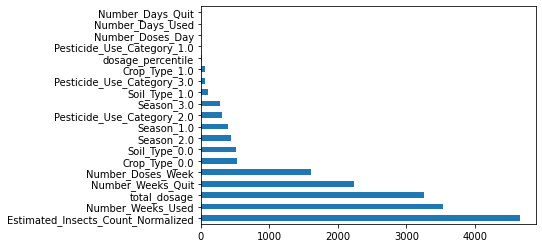

In [157]:
feat_importances = pd.Series(m.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [158]:
train_df

,ID,Estimated_Insects_Count,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Crop_Damage,Crop_Type_0.0,Crop_Type_1.0,Soil_Type_0.0,Soil_Type_1.0,Pesticide_Use_Category_1.0,Pesticide_Use_Category_2.0,Pesticide_Use_Category_3.0,Season_1.0,Season_2.0,Season_3.0,Number_Doses_Day,Number_Days_Used,Number_Days_Quit,total_dosage,dosage_percentile,Estimated_Insects_Count_Normalized
0,F00000001,188.0,0.0,0.0,0.0,0.0,0,1,1,0,1,0,0,1,0,0,0.000000,0.0,0.0,0.0,1.0,0.009628
1,F00000003,209.0,0.0,0.0,0.0,1.0,0,1,1,0,1,0,0,0,1,0,0.000000,0.0,0.0,0.0,1.0,0.014948
2,F00000004,257.0,0.0,0.0,0.0,1.0,0,1,1,0,1,0,0,0,1,0,0.000000,0.0,0.0,0.0,1.0,0.027109
3,F00000005,257.0,0.0,0.0,0.0,1.0,0,1,0,1,1,0,0,0,1,0,0.000000,0.0,0.0,0.0,1.0,0.027109
4,F00000006,342.0,0.0,0.0,0.0,1.0,0,1,1,0,1,0,0,0,1,0,0.000000,0.0,0.0,0.0,1.0,0.048645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88853,F00155935,3337.0,10.0,12.0,44.0,0.0,0,1,1,0,0,1,0,0,0,1,1.428571,84.0,308.0,120.0,1.0,0.807449
88854,F00155938,3516.0,10.0,20.0,38.0,0.0,0,1,1,0,0,1,0,1,0,0,1.428571,140.0,266.0,200.0,1.0,0.852800
88855,F00155939,3516.0,15.0,40.0,8.0,0.0,0,1,1,0,0,1,0,0,1,0,2.142857,280.0,56.0,600.0,2.0,0.852800
88856,F00155942,3702.0,10.0,25.0,18.0,0.0,0,1,1,0,0,1,0,0,0,1,1.428571,175.0,126.0,250.0,1.0,0.899924


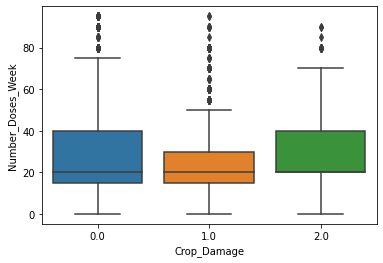

In [159]:
g = sns.boxplot(x='Crop_Damage',y="Number_Doses_Week", data=train_df)

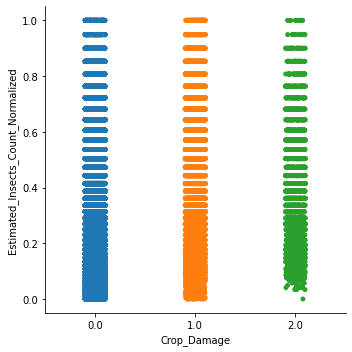

In [160]:
g = sns.catplot(x='Crop_Damage',y="Estimated_Insects_Count_Normalized",hue="Crop_Damage", data=train_df)

## Support Vector

In [38]:
from sklearn.svm import SVC
m5 = SVC()
#m5.fit(X_train,y_train)

In [ ]:
print_score(m5)

## Vec stacking

In [39]:
!pip install vecstack
from vecstack import stacking 

In [44]:
from sklearn.linear_model import LogisticRegression
m6 = LogisticRegression()
models = [m1, m2, m4, m5, m6]

# Compute stacking features
S_train, S_test = stacking(models, X, y, X_test,
    regression = False, n_folds = 4,
    shuffle = True, random_state = 88, verbose = 2)

task:         [classification]
n_classes:    [3]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [5]

model  0:     [RandomForestClassifier]
    fold  0:  [0.82111186]
    fold  1:  [0.81809588]
    fold  2:  [0.81799766]
    fold  3:  [0.81966328]
    ----
    MEAN:     [0.81921717] + [0.00127802]
    FULL:     [0.81921718]

model  1:     [LGBMClassifier]
    fold  0:  [0.84897592]
    fold  1:  [0.84843574]
    fold  2:  [0.84473755]
    fold  3:  [0.84518772]
    ----
    MEAN:     [0.84683423] + [0.00188804]
    FULL:     [0.84683427]

model  2:     [XGBClassifier]
    fold  0:  [0.84722035]
    fold  1:  [0.84758046]
    fold  2:  [0.84280184]
    fold  3:  [0.84410732]
    ----
    MEAN:     [0.84542749] + [0.00203018]
    FULL:     [0.84542754]

model  3:     [SVC]
    fold  0:  [0.83655188]
    fold  1:  [0.83560657]
    fold  2:  [0.83294319]
    fold  3:  [0.83672459]
    ----
    MEAN:     [0.83545656] + [0.00151221]
    FULL:     [0.83545657]

mode

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    fold  0:  [0.83353590]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    fold  1:  [0.83182534]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    fold  2:  [0.83325831]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


    fold  3:  [0.83357342]
    ----
    MEAN:     [0.83304824] + [0.00071646]
    FULL:     [0.83304823]



In [45]:
cat = catboost.CatBoostClassifier(iterations=100)
model = cat

In [47]:
model.fit(S_train,y)

Learning rate set to 0.5
0:	learn: 0.6437976	total: 93.5ms	remaining: 9.26s
1:	learn: 0.5438866	total: 124ms	remaining: 6.07s
2:	learn: 0.5017943	total: 158ms	remaining: 5.11s
3:	learn: 0.4833646	total: 194ms	remaining: 4.66s
4:	learn: 0.4750346	total: 226ms	remaining: 4.28s
5:	learn: 0.4708205	total: 259ms	remaining: 4.06s
6:	learn: 0.4693225	total: 292ms	remaining: 3.88s
7:	learn: 0.4689590	total: 325ms	remaining: 3.74s
8:	learn: 0.4686510	total: 356ms	remaining: 3.6s
9:	learn: 0.4684044	total: 389ms	remaining: 3.5s
10:	learn: 0.4682587	total: 429ms	remaining: 3.47s
11:	learn: 0.4682524	total: 461ms	remaining: 3.38s
12:	learn: 0.4682496	total: 493ms	remaining: 3.3s
13:	learn: 0.4681987	total: 528ms	remaining: 3.24s
14:	learn: 0.4681893	total: 562ms	remaining: 3.18s
15:	learn: 0.4681758	total: 596ms	remaining: 3.13s
16:	learn: 0.4681510	total: 636ms	remaining: 3.11s
17:	learn: 0.4681401	total: 669ms	remaining: 3.05s
18:	learn: 0.4681255	total: 704ms	remaining: 3s
19:	learn: 0.4681124	

In [48]:
y_test_pred = model.predict(S_test)

In [50]:
y_test_pred.shape

(59310, 1)

In [51]:
pd.Series(y_test_pred[:,0])

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
59305    0.0
59306    0.0
59307    0.0
59308    0.0
59309    0.0
Length: 59310, dtype: float64

In [52]:
submission_test_v1 = pd.concat([test_df['ID'],pd.Series(y_test_pred[:,0])],axis=1)

In [53]:
submission_test_v1.columns = ['ID','Crop_Damage']

In [54]:
submission_test_v1.to_csv("submission_v8_stack.csv",index=False)  #normalized and dummies